# Ventriloquist Effect

In this example we show how we can compare models in an audio-visual spatial disparity task to reproduce the Ventriloquist Effect as shown in:

>Paredes, R., Cabral, J. B., & Series, P. (2025). Scikit-NeuroMSI: A Generalized Framework for Modeling Multisensory Integration. bioRxiv, 2025-05. doi: https://doi.org/10.1101/2025.05.26.656124

## Implementation of models

For this paradigm we call the relevant models that account for spatial multisensory integration:

In [1]:
from skneuromsi.neural import Cuppini2017
from skneuromsi.neural import Paredes2025
from skneuromsi.mle import AlaisBurr2004
from skneuromsi.bayesian import Kording2007

model_alaisburr = AlaisBurr2004(position_range=(0, 90), position_res=1)
model_kording = Kording2007(position_range=(0, 90), position_res=1)
model_cuppini2017 = Cuppini2017(
    neurons=90, position_range=(0, 90), position_res=1
)
model_paredes = Paredes2025(
    neurons=90, position_range=(0, 90), position_res=1, time_range=(0, 100)
)
causal_model_paredes = Paredes2025(
    neurons=90, position_range=(0, 90), position_res=1, time_range=(0, 150)
)

temporal_model_kording = Kording2007(
    time_range=(0, 500), time_res=1, position_range=(0, 1), position_res=1
)

## Experiment setup

We are interested to explore implicit causal inference (auditory bias) and explicit causal inference (unity judgement) responses for audio-visual stimuli at different spatial disparities.

To simulate the explicit causal inference responses, we define a customized `ProcessingStrategy`:

In [2]:
import numpy as np
from skneuromsi.sweep import ProcessingStrategyABC


class CausesProcessingStrategy(ProcessingStrategyABC):
    def map(self, result):
        causes = result.causes_
        del result._nddata
        return causes

    def reduce(self, results, **kwargs):
        return np.array(results, dtype=np.float16)

Now we setup the experiment simulation for each model using the `ParameterSweep` class:

In [3]:
from skneuromsi.sweep import ParameterSweep

dis = np.array([-24, -12, -6, -3, 3, 6, 12, 24])  # spatial disparities

sp_alaisburr = ParameterSweep(
    model=model_alaisburr,
    target="visual_position",
    repeat=1,
    n_jobs=-2,
    range=45 + dis,
)

sp_kording = ParameterSweep(
    model=model_kording,
    target="visual_position",
    repeat=1,
    n_jobs=-2,
    range=45 + dis,
)

sp_cuppini2017 = ParameterSweep(
    model=model_cuppini2017,
    target="visual_position",
    repeat=1,
    n_jobs=-2,
    range=45 + dis,
)
sp_paredes = ParameterSweep(
    model=model_paredes,
    target="visual_position",
    repeat=1,
    n_jobs=-2,
    range=45 + dis,
)

causal_sp_kording = ParameterSweep(
    model=model_kording,
    target="visual_position",
    repeat=1,
    n_jobs=-2,
    range=45 + dis,
    processing_strategy=CausesProcessingStrategy(),
)

causal_sp_cuppini2017 = ParameterSweep(
    model=model_cuppini2017,
    target="visual_position",
    repeat=1,
    n_jobs=-2,
    range=45 + dis,
    processing_strategy=CausesProcessingStrategy(),
)

causal_sp_paredes = ParameterSweep(
    model=causal_model_paredes,
    target="visual_position",
    repeat=1,
    n_jobs=-2,
    range=45 + dis,
    processing_strategy=CausesProcessingStrategy(),
)

## Auditory Bias simulation

We are now ready to run the experiments and extract auditory bias responses:

In [4]:
res_alaisburr = sp_alaisburr.run(
    auditory_position=45,
    auditory_sigma=4.695e01,
    visual_sigma=4.505e01,
    noise=False,
)

res_kording = sp_kording.run(
    auditory_position=45,
    auditory_sigma=2.490e01,
    visual_sigma=2.171e01,
    prior_mu=4.069e01,
    prior_sigma=5.277e00,
    noise=False,
)

res_cuppini2017 = sp_cuppini2017.run(
    auditory_position=45,
    auditory_sigma=4.511e01,
    visual_sigma=2.495e01,
    auditory_intensity=1.191e01,
    visual_intensity=1.387e01,
    noise=False,
)
res_paredes = sp_paredes.run(
    auditory_position=45,
    auditory_sigma=2.000e01,
    visual_sigma=1.854e01,
    auditory_intensity=1.113e00,
    visual_intensity=7.728e00,
    noise=False,
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=100,
    visual_duration=100,
    auditory_onset=0,
    visual_onset=0,
)

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

## Spatial Causal Inference simulation

Next, we run the experiments to extract explicit causal inference responses:

>**Note:** For simplicity and computational efficiency, we are asking the models to provide causal inference responses as probability values (instead of counts) with the `causes_kind` argument.

In [5]:
res_kording_causes = causal_sp_kording.run(
    auditory_position=45,
    auditory_sigma=8.042e00,
    visual_sigma=8.041e00,
    noise=False,
    strategy="selection",
    prior_mu=6.898e01,
    prior_sigma=4.501e01,
    causes_kind="prob",
)

res_cuppini2017_causes = causal_sp_cuppini2017.run(
    auditory_position=45,
    auditory_sigma=2.803e01,
    visual_sigma=8.033e00,
    auditory_intensity=1.328e01,
    visual_intensity=2.366e01,
    noise=False,
    causes_kind="prob",
    causes_dim="space",
)

res_paredes_causes = causal_sp_paredes.run(
    auditory_position=45,
    auditory_sigma=4.215e01,
    visual_sigma=1.673e01,
    auditory_intensity=2.698e01,
    visual_intensity=4.776e00,
    noise=False,
    causes_kind="prob",
    causes_dim="space",
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=150,
    visual_duration=150,
    auditory_onset=0,
    visual_onset=0,
    causes_peak_threshold=0.15,
)

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

## Plotting

Finally we plot our results to visually compare the performance of the models:

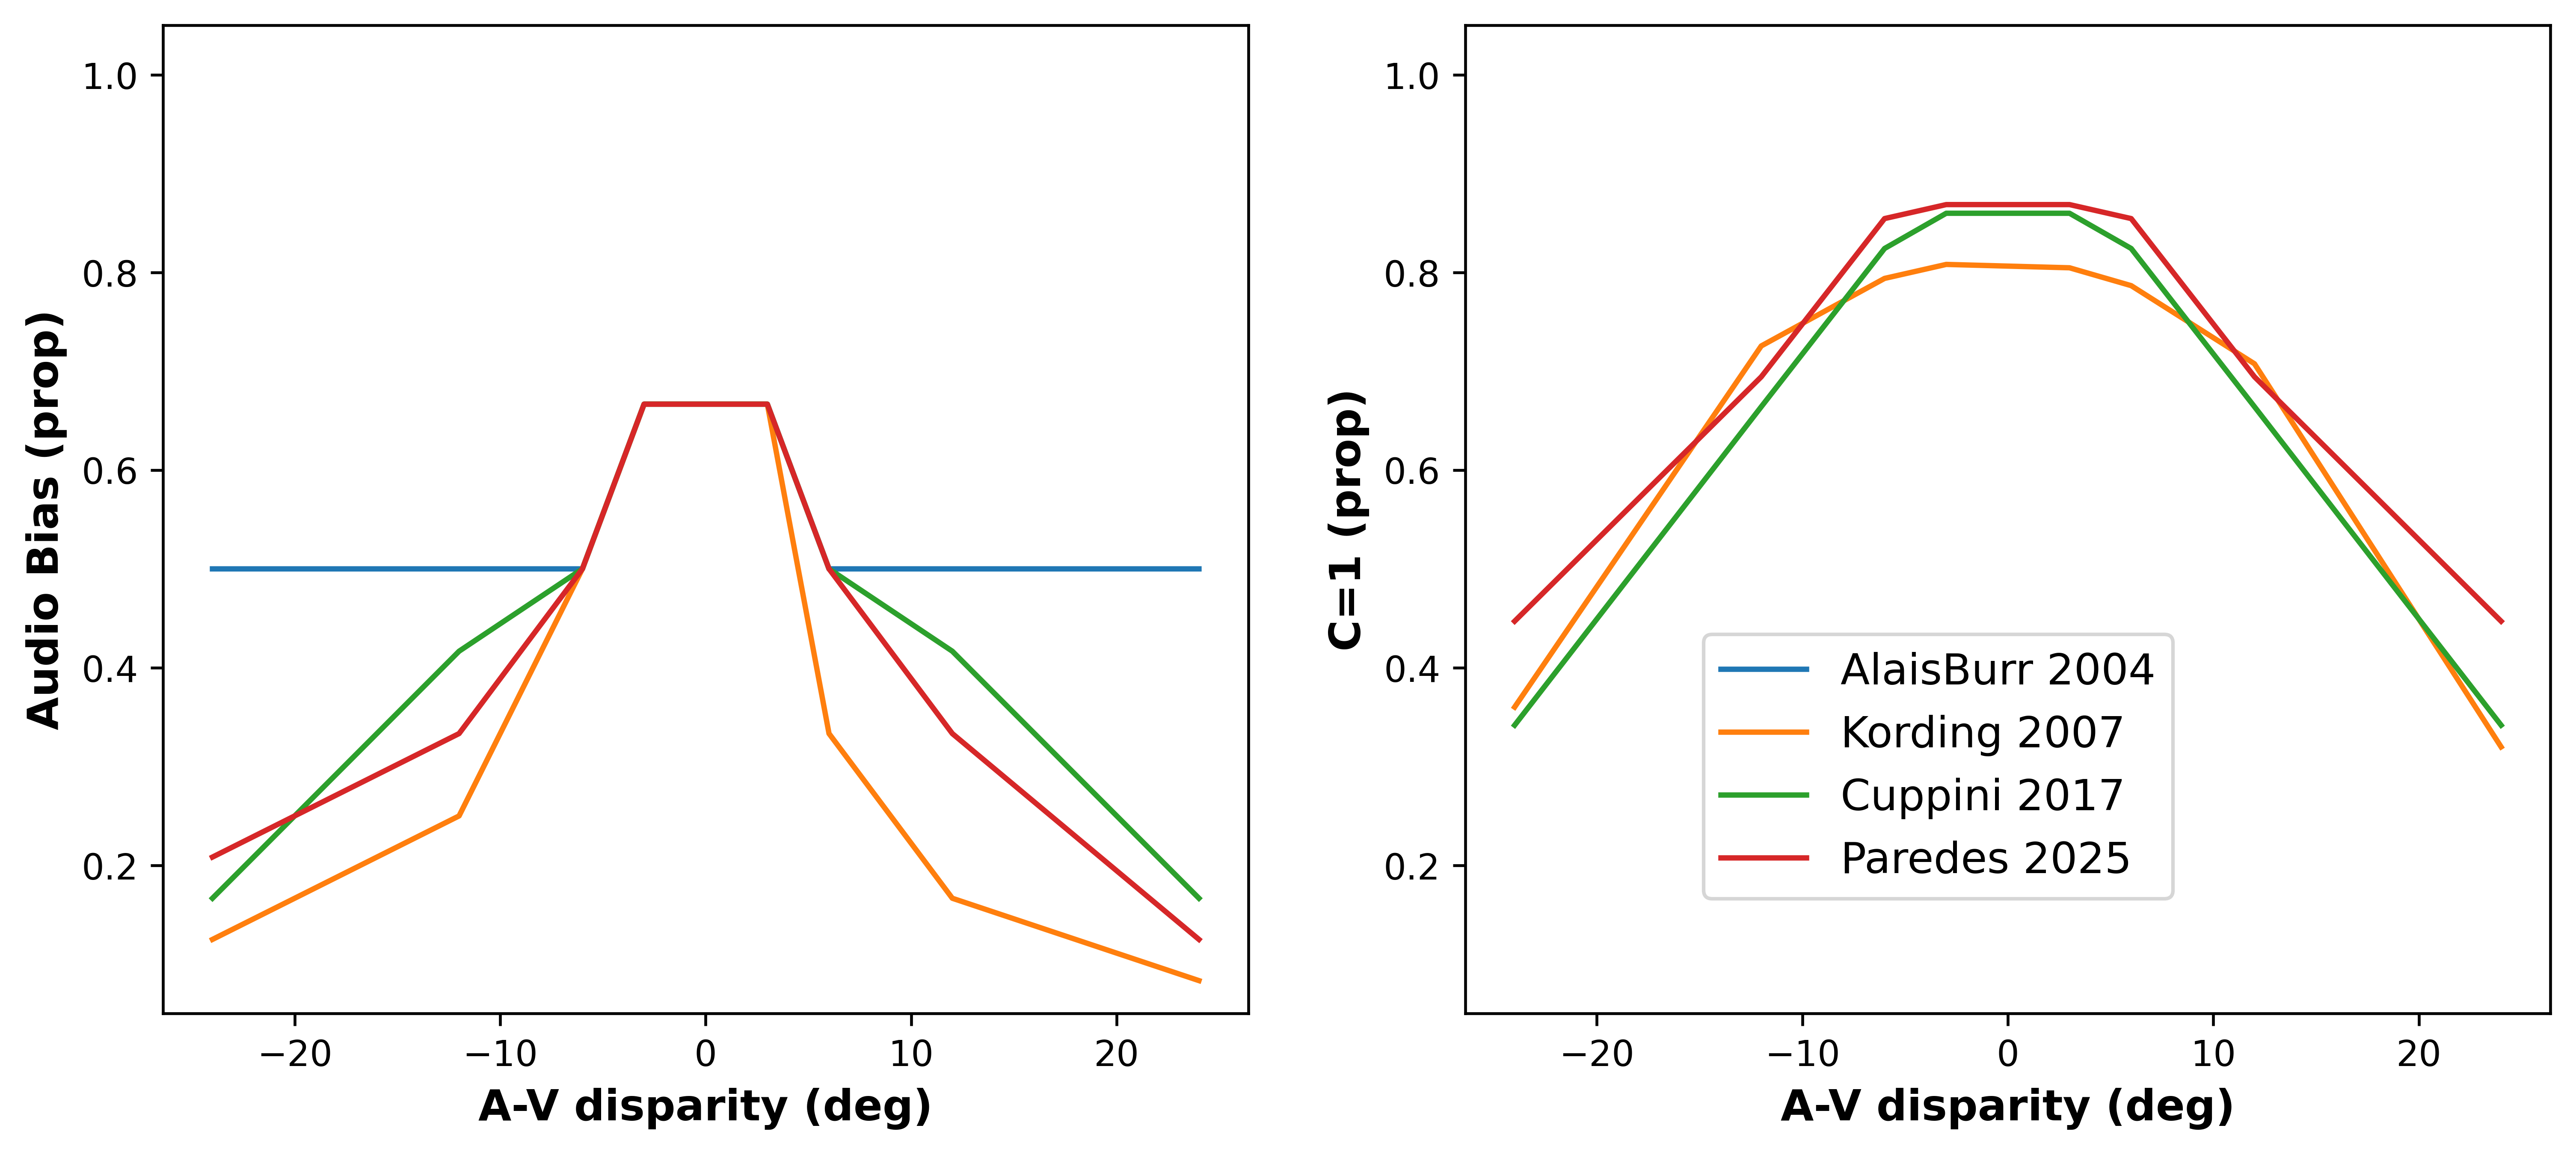

In [ ]:
import matplotlib.pyplot as plt

# initializes figure and plots
fig, axs = plt.subplots(
    1, 2, figsize=(12, 5), sharex=False, dpi=600, gridspec_kw={"hspace": 0.3}
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Panel A
ax1 = plt.subplot(121)
res_alaisburr.bias.bias_mean(
    influence_parameter="auditory_position", mode="multi"
).plot(ax=ax1)
res_kording.bias.bias_mean(
    influence_parameter="auditory_position", mode="auditory"
).plot(ax=ax1)
res_cuppini2017.bias.bias_mean(
    influence_parameter="auditory_position", mode="auditory"
).plot(ax=ax1)
res_paredes.bias.bias_mean(
    influence_parameter="auditory_position", mode="auditory"
).plot(ax=ax1)
ax1.set_ylim(0.05, 1.05)
ax1.set_xlabel("A-V disparity (deg)", size=12, weight="bold")
ax1.set_ylabel("Auditory Bias (prop)", size=12, weight="bold")
ax1.tick_params(axis="both", labelsize=10)

legend = ax1.legend(
    [
        "AlaisBurr 2004",
        "Kording 2007",
        "Cuppini 2017",
        "Paredes 2025",
        "Noel 2022 data",
    ],
    fontsize=12,
    loc="center left",
    bbox_to_anchor=(1.4, 0.25),
)
ax1.get_legend().remove()

# Panel B
ax2 = plt.subplot(122)
ax2.set_prop_cycle(color=colors[1:4])
ax2.plot(dis, res_kording_causes)
ax2.plot(dis, res_cuppini2017_causes)
ax2.plot(dis, res_paredes_causes)
ax2.set_ylim(0.05, 1.05)
ax2.set_xlabel("A-V disparity (deg)", size=12, weight="bold")
ax2.set_ylabel("C=1 (prop)", size=12, weight="bold")
ax2.tick_params(axis="both", labelsize=10)
ax2.add_artist(legend)